## Example of generating a pointing script for observations with the ARO 46-m

A few things to keep in mind: 
* ARO slews at ~7-8 deg per minute
* Start tracking your source ~30 sec before you want good data to prevent oscillations
* For steady slewing, you should have one entry in the pointing script per second
* ARO can slew clockwise from 41 degrees, through 360 degrees, to 51 degrees.
* The script does not allow you to specify the direction of slews - if you are near the cable wrap, explain how you need to slew to the operator.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [2]:
def append_to_fazel_file(file,times,az,alt):
    """Writes pointing commands to the fazel file.
    Parameters:
    -----------
    file:  open file handler
    times: Array of Astropy Times
    az:    Array of Astropy Quantities, angles, azimuth pointing at each time
    alt:   Array of Astropy Quantities, angles, altitude pointing at each time
    """
    for i in np.arange(len(times)):
        f.write( times[i].yday.replace(':','.',2) + " " 
                +  az[i].to_string(sep=' ') + " 0.1 " 
                + alt[i].to_string(sep=' ') + " 0.4 \n")

In [3]:
def account_for_offsets(altazs,daz0=-3.25*u.deg,dalt0=-3.45*u.deg,alt0=11.90*u.deg):
    """Calculates where the prime axis of the telescope must point in order to account for the
    offsets of the off-axis feed from the prime axis.
    Parameters:
    -----------
    altazs: Astropy SkyCoord, the location of your target source.
    daz0:   Astropy quantity (angle), azimuth offset.  Default is CHIME off-axis feed 2018 offsets.
    dalt0:  Astropy quantity (angle), altitude offset. Default is CHIME off-axis feed 2018 offsets.
    alt0:   Astropy quantity (angle), altitude pointing when azimuth offset measured. 
            Default is CHIME off-axis feed 2018 offsets.
    Returns:
    -----------
    az_off:  Astropy quantity (angle), the azimuth pointing that will 
             cause the off-axis feed to be pointing on target.
    alt_off: Astropy quantity (angle), the altitude pointing that will
             cause the off-axis feed to be pointing on target.
    """
    daz      = daz0*np.cos(alt0)/np.cos(altazs.alt)
    alt_off  = altazs.alt + dalt0
    az_off   = (altazs.az + daz)%(360.*u.deg)
    return az_off,alt_off

Set the observatory location and the date of observations.

In [4]:
ARO = EarthLocation(lat=45.95550333*u.deg, lon=-78.073040402778*u.deg, height=260.4*u.m)
date = '2018-12-06' 
midnight = Time(date+'T00:00:00')

Read in the observation plan and coordinates from csv files.

In [5]:
df = pandas.read_csv('planning.csv', 
            header=0, 
            names=['source', 'type','start_time', 'stop_time'])

In [6]:
df

,source,type,start_time,stop_time
0,B0329+54,PSR,1:25 AM,1:30 AM
1,J0347+5557,CAL,1:33 AM,1:38 AM
2,B0329+54,PSR,1:40 AM,1:45 AM
3,J0347+5557,CAL,1:48 AM,1:53 AM


In [7]:
coor = pandas.read_csv('coordinates.csv',
                      header=0,
                      index_col='source',
                      names=['source','ra','dec'])
coor = coor.drop_duplicates()

Create astropy SkyCoord and Time objects from the source coordinates and start and stop times.

In [8]:
sources = []
start_times = []
stop_times = []
for i in range(df.shape[0]):
    sources += [SkyCoord(ra=coor['ra'][df['source'][i]].astype(float)*u.deg,
                         dec=coor['dec'][df['source'][i]].astype(float)*u.deg)]
    start_times += [Time(date+'T0'+df['start_time'][i].split()[0]+':00')+5*u.h]
    stop_times  += [Time(date+'T0'+df['stop_time'][i].split()[0]+':00')+5*u.h]

In [9]:
# Get on source ~10 minutes early for the first observation.
start_time = start_times[0] - 10*u.min

### Take a look at the observation plan

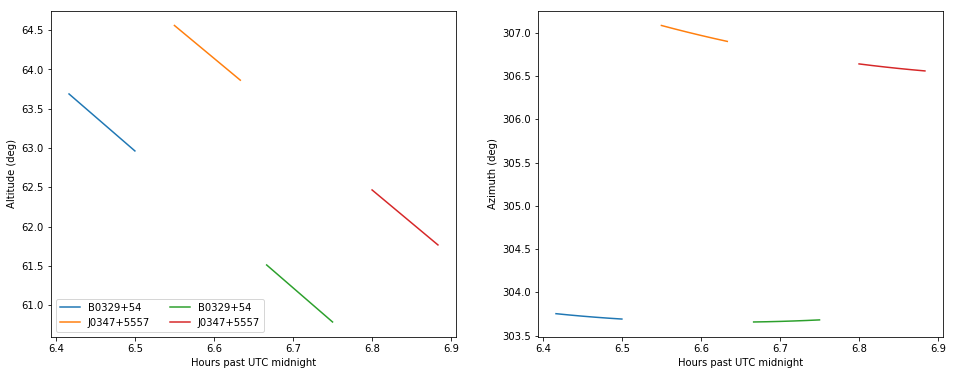

In [10]:
fig,ax = plt.subplots(1,2,sharex=True,figsize=(16,6))
for i in range(df.shape[0]):
    ax[0].plot(np.arange((start_times[i]-midnight).to(u.h).value,(stop_times[i]-midnight).to(u.h).value,1/60),
               sources[i].transform_to(AltAz(obstime=np.arange(start_times[i],stop_times[i],1/60*u.h),
                                             location=ARO)).alt,label=df['source'][i])
    ax[1].plot(np.arange((start_times[i]-midnight).to(u.h).value,(stop_times[i]-midnight).to(u.h).value,1/60),
               sources[i].transform_to(AltAz(obstime=np.arange(start_times[i],stop_times[i],1/60*u.h),
                                             location=ARO)).az,label=df['source'][i])
ax[0].set_ylabel('Altitude (deg)')
ax[1].set_ylabel('Azimuth (deg)')
ax[0].set_xlabel('Hours past UTC midnight')
ax[1].set_xlabel('Hours past UTC midnight')

ax[0].legend(loc='lower left',ncol=2)
    
    

### Write Fazel File

In [11]:
f = open('example_fazel.txt','w')
f.write("# Example fazel file\n")
for i in range(df.shape[0]):
    if i==0:
        times = np.arange(start_time,stop_times[i],1*u.s)
    else:
        times = np.arange(stop_times[i-1]+1*u.s,stop_times[i],1*u.s)
    frames = AltAz(obstime=times,location=ARO)
    altazs = sources[i].transform_to(frames)
    az,alt = account_for_offsets(altazs)
    append_to_fazel_file(f,times,az,alt)
f.close()

### Check Fazel File

In [12]:
fazel = np.loadtxt('example_fazel.txt',skiprows=1,dtype=str)

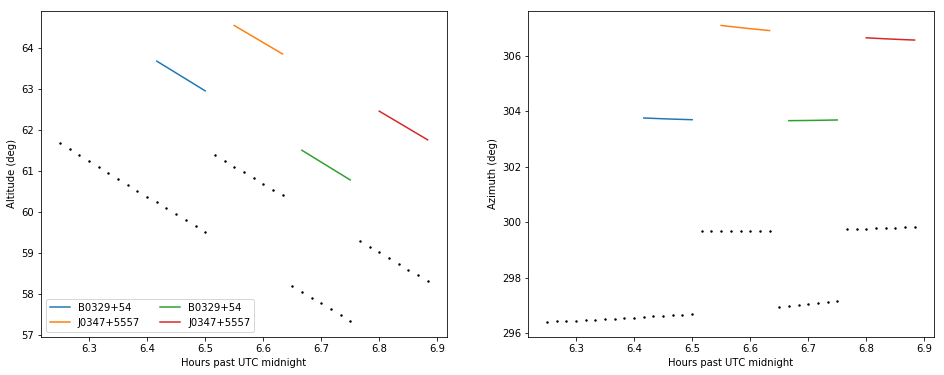

In [14]:
fig,ax = plt.subplots(1,2,sharex=True,figsize=(16,6))
for i in range(df.shape[0]):
    ax[0].plot(np.arange((start_times[i]-midnight).to(u.h).value,(stop_times[i]-midnight).to(u.h).value,1/60),
               sources[i].transform_to(AltAz(obstime=np.arange(start_times[i],stop_times[i],1/60*u.h),
                                             location=ARO)).alt,label=df['source'][i])
    ax[1].plot(np.arange((start_times[i]-midnight).to(u.h).value,(stop_times[i]-midnight).to(u.h).value,1/60),
               sources[i].transform_to(AltAz(obstime=np.arange(start_times[i],stop_times[i],1/60*u.h),
                                             location=ARO)).az,label=df['source'][i])
ax[0].set_ylabel('Altitude (deg)')
ax[1].set_ylabel('Azimuth (deg)')
ax[0].set_xlabel('Hours past UTC midnight')
ax[1].set_xlabel('Hours past UTC midnight')

ax[0].legend(loc='lower left',ncol=2)

for i in range(0,fazel.shape[0],60):
    ax[1].scatter((Time(fazel[i][0].replace('.',':',2))-midnight).to(u.h).value,
               (fazel[i][1].astype(float)*u.deg + fazel[i][2].astype(float)*u.arcmin + 
                fazel[i][3].astype(float)*u.arcsec).to(u.deg),
              color='black',s=2)
    ax[0].scatter((Time(fazel[i][0].replace('.',':',2))-midnight).to(u.h).value,
              (fazel[i][5].astype(float)*u.deg + fazel[i][6].astype(float)*u.arcmin + 
               fazel[i][7].astype(float)*u.arcsec).to(u.deg),
              color='black',s=2)